## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import mne
from scipy.integrate import trapezoid
import pandas as pd
from scipy.stats import ttest_rel

## Defining Important Features

We will be performing two sets of analyses: 
1. Using a small sample of 5 subjects
2. Using a larger sample of 26 subjects, that we will treat as our main analysis

We want to see if sample size affects our results as we wanted to selects a manageable subset of the data.

In [2]:
DATASET_PATH = './data/'  # Update if needed

SUBJECTS = ["S001", "S002", "S003", "S004", "S006","S007", "S008", "S009", "S010","S011", "S012", "S013", "S014", "S015", "S020","S021", "S022", "S023", "S024", "S025", "S075", "S076", "S077", "S078", "S079", "S080"]  
REAL_MOVEMENT_RUNS = ["R03", "R04", "R05", "R07", "R09", "R13"]  
IMAGINED_MOVEMENT_RUNS = ["R06", "R08", "R10", "R11", "R12", "R14"]  


SMALL_SAMPLE_SUBJECTS = ["S001", "S002", "S003", "S004", "S005"]  
SMALL_SAMPLE_REAL_MOVEMENT_RUNS = ["R03", "R04", "R07"]  
SMALL_SAMPLE_IMAGINED_MOVEMENT_RUNS = ["R08", "R11", "R12"]  

PROCESSED_CHANNELS = ['C3..', 'Cz..', 'C4..']  


SFREQ = 160  
LOW_CUT = 1  
HIGH_CUT = 40  
NOTCH_FREQ = 60  

bands = {
    'theta': (4, 7),
    'alpha': (8, 13),
    'beta': (14, 30),
    'gamma': (30, 40)
}

Before we begin any processing, we will first plot out the signals to check for any artifacts. Let us look at a random 5 second section from subject 1's R08 run.

Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


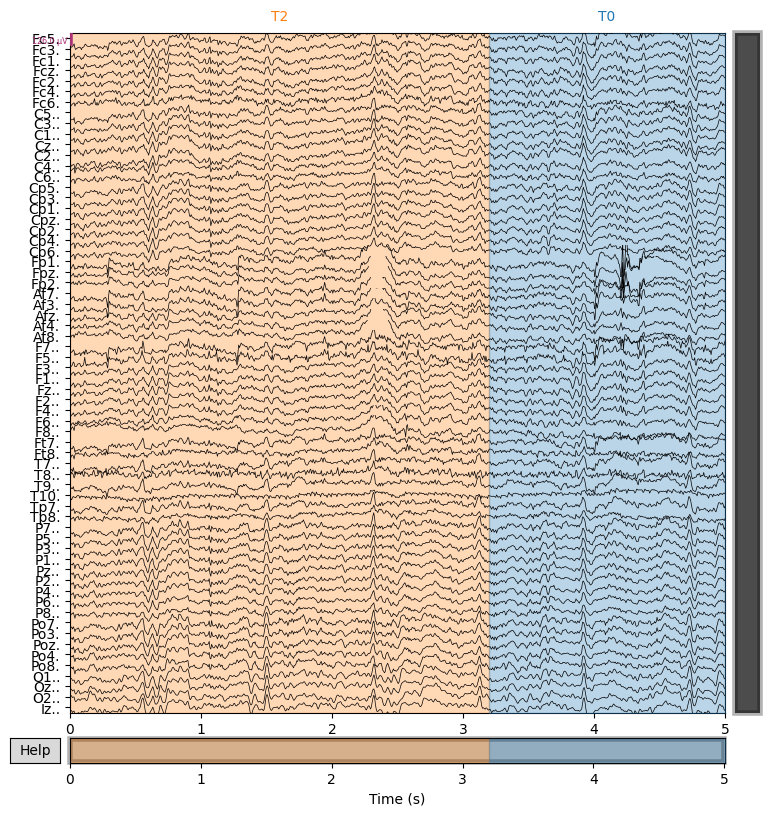

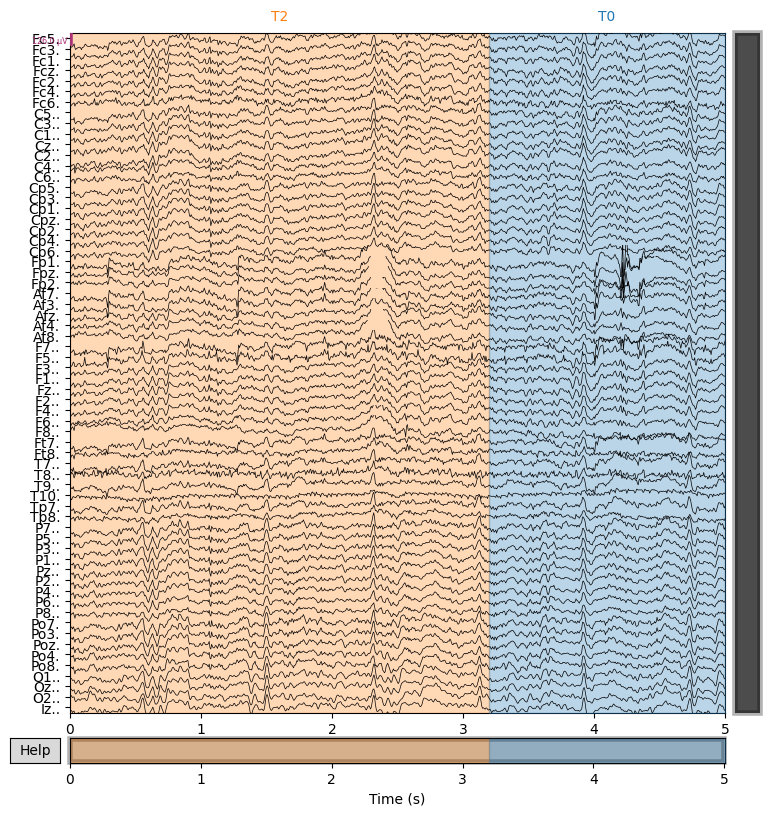

In [30]:
subject = 'S001'
run = 'R08'
edf_file = os.path.join(DATASET_PATH, subject, f"{subject}{run}.edf")
raw = mne.io.read_raw_edf(edf_file, preload=True)

#raw.pick(['Fp1.', 'Fp2.', "C3..", "Cz..", "C4.."])  

start_time = 30  # Change as desired (secs)
end_time = 35    # Change as desired

sfreq = raw.info['sfreq']  
start_sample = int(start_time * sfreq)
end_sample = int(end_time * sfreq)

raw_selection = raw.copy().crop(tmin=start_time, tmax=end_time)
raw_selection.plot(
    n_channels=len(raw.ch_names),  
    scalings="auto",               
    remove_dc=True,               
    title="Wider EEG Plot",
    block=True,
    show=True,
)

we can clearly see some sort of sharp, high deflection artifact that is clearly visible in Fp1, Fp2, Fpz channels, at around 4.2 seconds. Let us zoom in and also check the frequecy. 

Effective window size : 5.006 (s)
Plotting power spectral density (dB=True).


/var/folders/fs/b6n1rrm11k96n9qwk9cl0gc00000gn/T/ipykernel_71717/629654440.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_selection.compute_psd().plot()
/Users/ananyakrishnan/miniconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


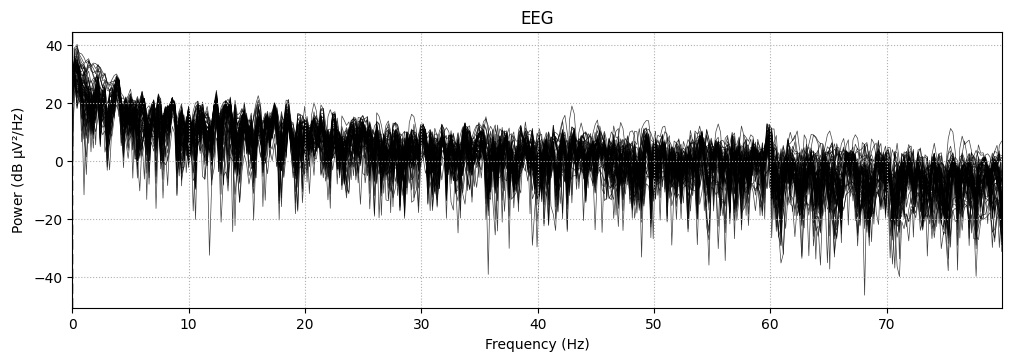

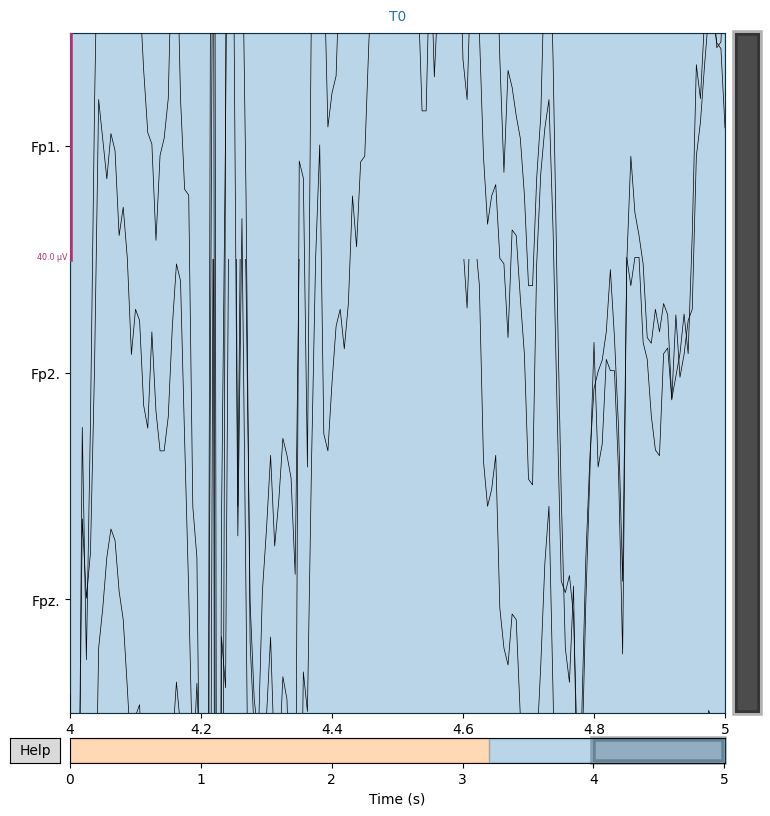

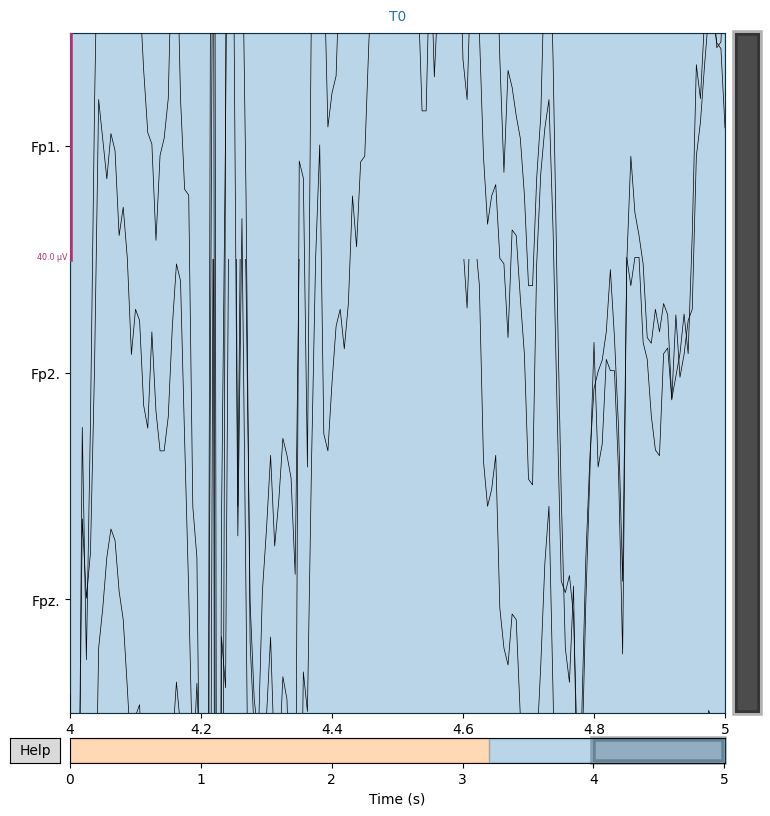

In [31]:
raw_selection.compute_psd().plot()
raw_selection.copy().pick(['Fp1.', 'Fp2.', 'Fpz.']).plot(duration=1, start=4, n_channels=3)

The artifact has rapid onset and offset, unlike slow eye blinks. There is some power distributed across 20–40 Hz, which could indicate muscle activity, but no distinct peak in the blink-related delta (~1 Hz) or theta (4–7 Hz) range. This suggests a muscle-related origin rather than an eye blink.

Let us look at another subject, S075, in run  R13.

Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S075/S075R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


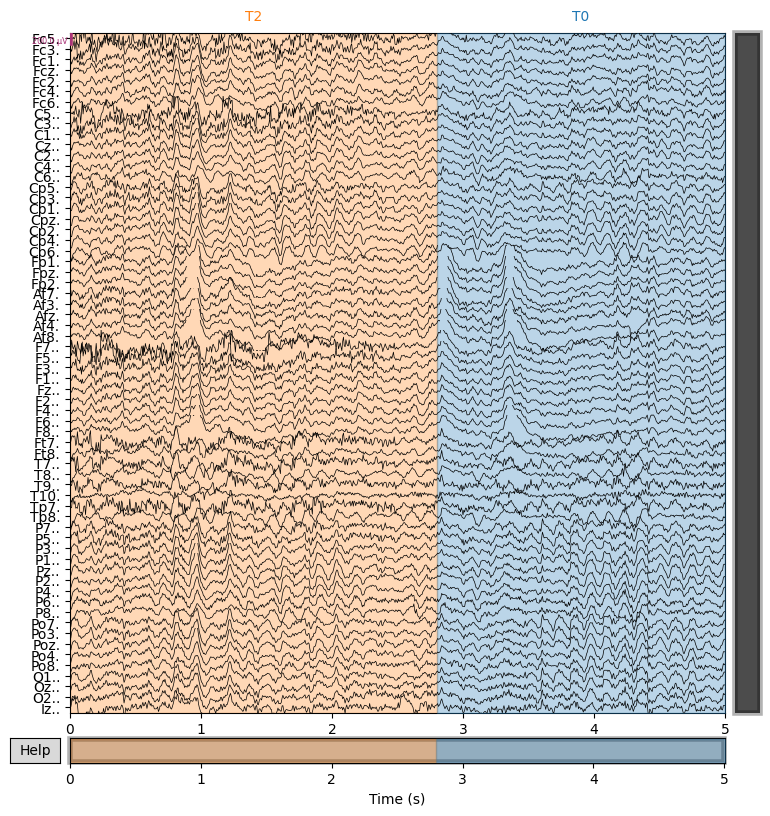

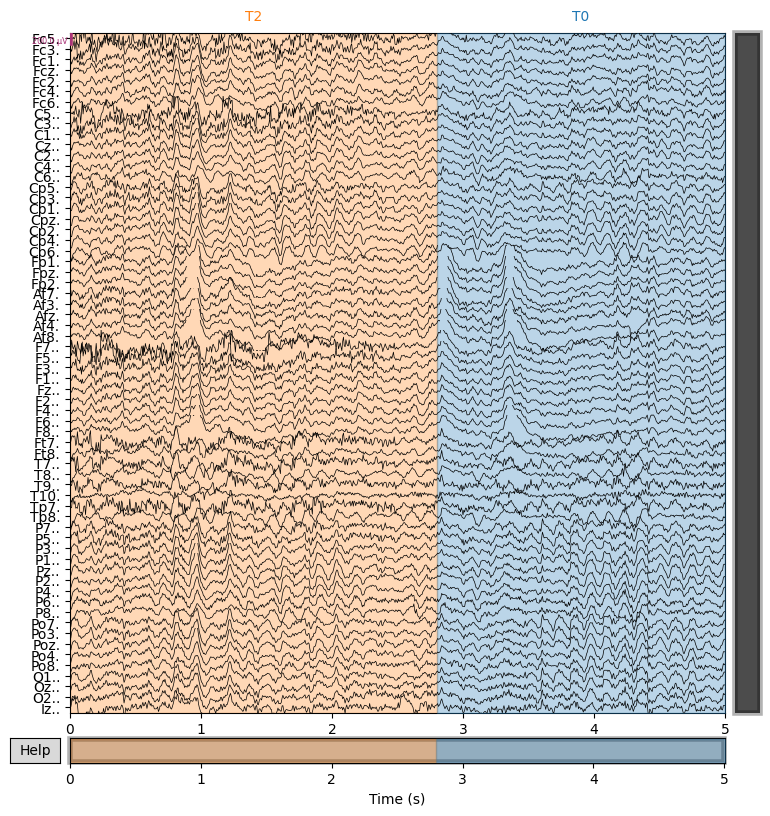

In [32]:
subject = 'S075'
run = 'R13'
edf_file = os.path.join(DATASET_PATH, subject, f"{subject}{run}.edf")
raw = mne.io.read_raw_edf(edf_file, preload=True)

#raw.pick(['Fp1.', 'Fp2.', "C3..", "Cz..", "C4.."])  

start_time = 30  # Change as desired (secs)
end_time = 35    # Change as desired

sfreq = raw.info['sfreq']  
start_sample = int(start_time * sfreq)
end_sample = int(end_time * sfreq)

raw_selection = raw.copy().crop(tmin=start_time, tmax=end_time)
raw_selection.plot(
    n_channels=len(raw.ch_names),  
    scalings="auto",               
    remove_dc=True,               
    title="Wider EEG Plot",
    block=True,
    show=True,
)

At around 2.8 seconds, there appears to be an artifact in Fp1, Fp2, Fpz channels. Let us look at the frequency and zoom into the signals again.

Effective window size : 5.006 (s)
Plotting power spectral density (dB=True).


/var/folders/fs/b6n1rrm11k96n9qwk9cl0gc00000gn/T/ipykernel_71717/2649537588.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_selection.compute_psd().plot()
/Users/ananyakrishnan/miniconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


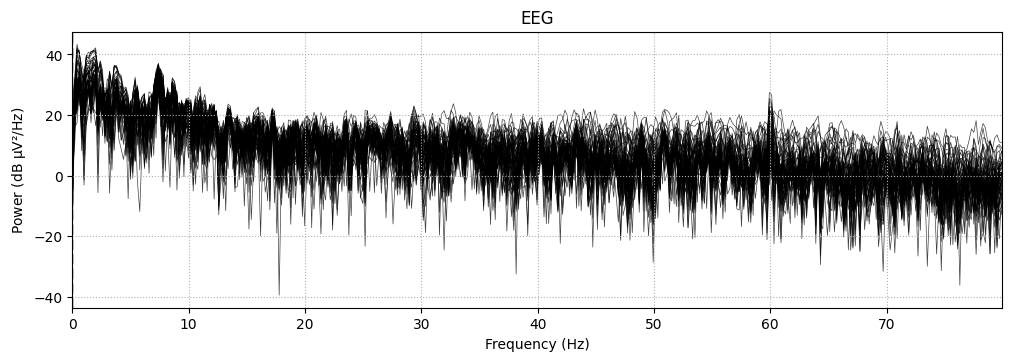

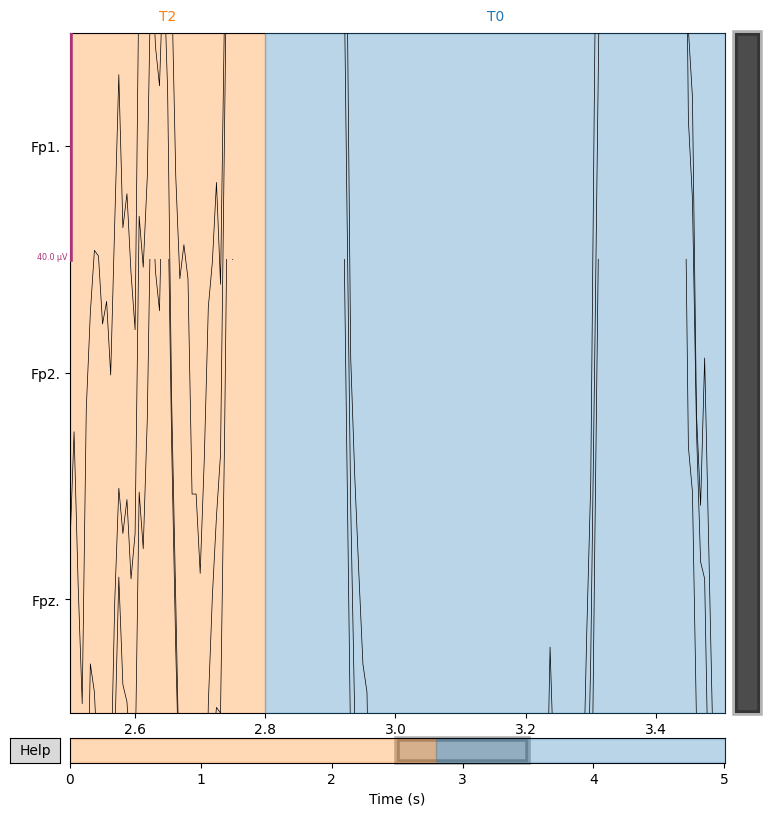

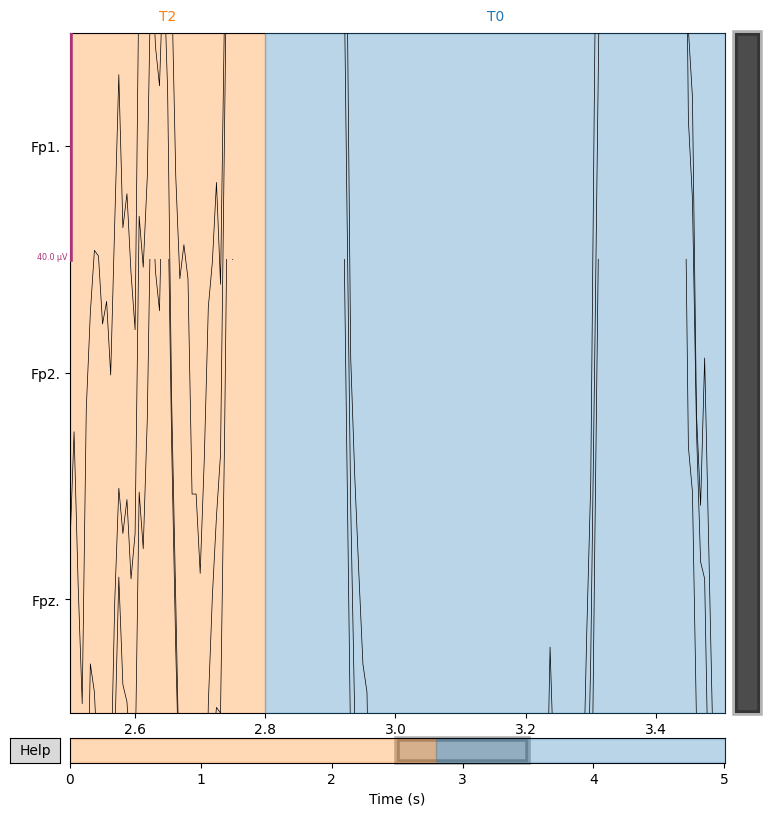

In [36]:
raw_selection.compute_psd().plot()
raw_selection.copy().pick(['Fp1.', 'Fp2.', 'Fpz.']).plot(duration=1, start=2.5, n_channels=3)

We see a large, slow wave with a peak and return to baseline from 2.6 to 2.8 seconds. Peak power is in the 0.5–3 Hz range and there io strong activity in the high-frequency range (>30 Hz), which would indicate muscle activity. Unlike muscle artifacts, this is a smooth slow wave, suggesting an eye blink

Similarly, while looking through the signals, we see other artifacts that could be eye blinks or other muscle activity. We will not focus on removing them for our analysis right now, but in the future, performing ICA would be useful to clean the signals.

# Setting up the functions

## Processing

To process the data we will apply notch filter and 4th-order Butterworth bandpass filter with a 1-40 Hz frequency range. We will then compute PSD using the Welch method to estimate the power distribution across Alpha, Beta, Gamma, and Theta frequency bands.

In [9]:
def process_signal(subjects, real_runs, imag_runs, data_path=DATASET_PATH):
   
    results = {
        'real_movement': {'raw': {}, 'processed': {}},
        'imagined_movement': {'raw': {}, 'processed': {}}
    }

    for subject in subjects:
        print(f"Processing subject {subject}...")
        
        for movement_type, runs in zip(['real_movement', 'imagined_movement'], 
                                       [real_runs, imag_runs]):
            for run in runs:
                edf_file = os.path.join(data_path, subject, f"{subject}{run}.edf")
                try:
                    raw = mne.io.read_raw_edf(edf_file, preload=True)
                    raw.pick(PROCESSED_CHANNELS)

                    results[movement_type]['raw'].setdefault(subject, {})[run] = {
                        ch: raw.get_data(picks=[ch])[0] for ch in PROCESSED_CHANNELS
                    }

                    raw.notch_filter(NOTCH_FREQ, fir_design='firwin')
                    raw.filter(l_freq=LOW_CUT, h_freq=HIGH_CUT,
                               method='fir', fir_design='firwin')

                    processed_data = {ch: {} for ch in PROCESSED_CHANNELS}
                    
                    for ch in PROCESSED_CHANNELS:
                        signal = raw.get_data(picks=[ch])[0]
                        freqs, psd = welch(signal, fs=SFREQ,
                                           nperseg=min(len(signal)//2, 128))

                        for band_name, (fmin, fmax) in bands.items():
                            idx = np.logical_and(freqs >= fmin, freqs <= fmax)
                            processed_data[ch][band_name] = (
                                trapezoid(psd[idx], freqs[idx])
                                if np.any(idx) else 0.0
                            )
                        
                        processed_data[ch]['freqs'] = freqs
                        processed_data[ch]['psd'] = psd

                    results[movement_type]['processed'].setdefault(subject, {})[run] = processed_data
                
                except Exception as e:
                    print(f"Error processing {subject} {run}: {e}")
    
    return results

### Structuring into dataframe

In [10]:
def combine_processed_data(results):
    rows = []
    
    for movement_type in ['real_movement', 'imagined_movement']:
        for subject, run_dict in results[movement_type]['processed'].items():
            for run, channels_data in run_dict.items():
                for ch, features in channels_data.items():
                    row = {
                        'movement_type': movement_type.replace('_movement', ''),
                        'subject': subject,
                        'run': run,
                        'channel': ch
                    }
                    for band_name in bands.keys():
                        row[band_name] = features[band_name]
                    
                    rows.append(row)
    
    df = pd.DataFrame(rows)
    df.to_csv('processed_band_powers.csv', index=False)
    
    return df

## Visualizations

In [11]:
def plot_psd(subject, channel, results):
    
    plt.figure(figsize=(10, 5))
    
    for movement_type, label, color in zip(
        ['real_movement', 'imagined_movement'], 
        ['Real Movement', 'Imagined Movement'], 
        ['blue', 'red']
    ):
        if subject in results[movement_type]['processed']:
            for run in results[movement_type]['processed'][subject]:
                if channel in results[movement_type]['processed'][subject][run]:
                    data = results[movement_type]['processed'][subject][run]
                    freqs, psd = data[channel]['freqs'], data[channel]['psd']
                    plt.plot(freqs, psd, label=label, color=color)
                    break
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Power Spectral Density - {subject} {channel}")
    plt.legend()
    plt.grid(True)
    plt.xlim(LOW_CUT, HIGH_CUT)
    plt.show()

def plot_band_powers(df):

    avg_band_powers = df.groupby('movement_type')[list(bands.keys())].mean()
    
    plt.figure(figsize=(8, 5))
    avg_band_powers.T.plot(kind='bar')
    plt.ylabel("Power (µV²/Hz)")
    plt.title("Average Power in EEG Frequency Bands")
    plt.grid(True)
    plt.show()


def plot_avg_psd(subjects, real_movement_runs, imagined_movement_runs, results, channel="C3.."):
    
    real_subject_psds = []
    imagined_subject_psds = []
    
    for subj in subjects:
        subject_real_run_psds = []
        subject_imagined_run_psds = []
        
        if subj in results['real_movement']['processed']:
            for run in real_movement_runs:
                if run in results['real_movement']['processed'][subj]:
                    if channel in results['real_movement']['processed'][subj][run]:
                        psd = results['real_movement']['processed'][subj][run][channel]['psd']
                        subject_real_run_psds.append(psd)
        
        if subj in results['imagined_movement']['processed']:
            for run in imagined_movement_runs:
                if run in results['imagined_movement']['processed'][subj]:
                    if channel in results['imagined_movement']['processed'][subj][run]:
                        psd = results['imagined_movement']['processed'][subj][run][channel]['psd']
                        subject_imagined_run_psds.append(psd)
        
        if subject_real_run_psds:
            real_subject_psds.append(np.mean(subject_real_run_psds, axis=0))
        if subject_imagined_run_psds:
            imagined_subject_psds.append(np.mean(subject_imagined_run_psds, axis=0))
    
    real_subject_psds = np.array(real_subject_psds)
    imagined_subject_psds = np.array(imagined_subject_psds)
    
    if len(real_subject_psds) == 0 or len(imagined_subject_psds) == 0:
        print("No PSD data found for the given subjects/runs.")
        return
    
    mean_real_psd = np.mean(real_subject_psds, axis=0)
    sem_real_psd = np.std(real_subject_psds, axis=0) / np.sqrt(real_subject_psds.shape[0])
    
    mean_imag_psd = np.mean(imagined_subject_psds, axis=0)
    sem_imag_psd = np.std(imagined_subject_psds, axis=0) / np.sqrt(imagined_subject_psds.shape[0])
    
    any_subj = subjects[0]
    first_run = real_movement_runs[0]
    freqs = results['real_movement']['processed'][any_subj][first_run][channel]['freqs']
    
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_real_psd, label="Real Movement - Avg", color="blue")
    plt.fill_between(freqs, mean_real_psd - sem_real_psd, mean_real_psd + sem_real_psd,
                     color="blue", alpha=0.3)
    
    plt.plot(freqs, mean_imag_psd, label="Imagined Movement - Avg", color="red")
    plt.fill_between(freqs, mean_imag_psd - sem_imag_psd, mean_imag_psd + sem_imag_psd,
                     color="red", alpha=0.3)
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Average PSD - {channel}")
    plt.legend()
    plt.grid(True)
    plt.xlim(LOW_CUT, HIGH_CUT)
    plt.show()


## Statistical Test

We will perform a paired t-test to determine if the differences between real and imagined movement signals are significant or just random variations.

In [15]:
def perform_t_test(subjects, real_movement_runs, imagined_movement_runs, results, channel='C3..', band='alpha'):
   
    real_band_powers = []
    imagined_band_powers = []

    for subj in subjects:
        if (subj in results['real_movement']['processed'] and
            subj in results['imagined_movement']['processed']):
            
            real_values = []
            imag_values = []
            
            for run in real_movement_runs:
                if (run in results['real_movement']['processed'][subj] and
                    channel in results['real_movement']['processed'][subj][run]):
                    val = results['real_movement']['processed'][subj][run][channel][band]
                    real_values.append(val)

            for run in imagined_movement_runs:
                if (run in results['imagined_movement']['processed'][subj] and
                    channel in results['imagined_movement']['processed'][subj][run]):
                    val = results['imagined_movement']['processed'][subj][run][channel][band]
                    imag_values.append(val)

            if real_values and imag_values:
                real_band_powers.append(np.mean(real_values))
                imagined_band_powers.append(np.mean(imag_values))

    real_band_powers = np.array(real_band_powers)
    imagined_band_powers = np.array(imagined_band_powers)

    if len(real_band_powers) != len(imagined_band_powers):
        raise ValueError("Paired arrays must have same length. Check data pairing.")
    if len(real_band_powers) == 0:
        print("No valid data for T-test. Check your subjects/runs.")
        return

    t_stat, p_value = ttest_rel(real_band_powers, imagined_band_powers)
    
    print(f"Paired T-test results for {band} band in {channel}:")
    print(f" T-statistic: {t_stat:.3f}")
    print(f" P-value: {p_value:.3f}")
    
    if p_value < 0.05:
        print(" The difference between real and imagined movement is STATISTICALLY SIGNIFICANT.")
    else:
        print(" The difference between real and imagined movement is NOT statistically significant.")


# Testing on small sample data

In [12]:
small_sample_results = process_signal(
    subjects=SMALL_SAMPLE_SUBJECTS,
    real_runs=SMALL_SAMPLE_REAL_MOVEMENT_RUNS,
    imag_runs=SMALL_SAMPLE_IMAGINED_MOVEMENT_RUNS
)
small_sample_df = combine_processed_data(small_sample_results)

Processing subject S001...
Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

In [16]:
perform_t_test(
    subjects=SMALL_SAMPLE_SUBJECTS,
    real_movement_runs=SMALL_SAMPLE_REAL_MOVEMENT_RUNS,
    imagined_movement_runs=SMALL_SAMPLE_IMAGINED_MOVEMENT_RUNS,
    results=small_sample_results,
    channel='C3..', band='alpha'
)

Paired T-test results for alpha band in C3..:
 T-statistic: -1.395
 P-value: 0.235
 The difference between real and imagined movement is NOT statistically significant.


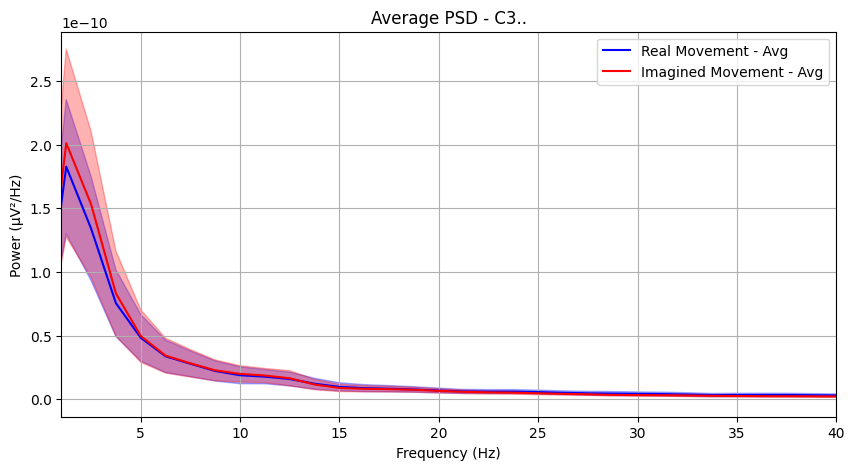

In [18]:
plot_avg_psd(
    subjects=SMALL_SAMPLE_SUBJECTS,
    real_movement_runs=SMALL_SAMPLE_REAL_MOVEMENT_RUNS,
    imagined_movement_runs=SMALL_SAMPLE_IMAGINED_MOVEMENT_RUNS,
    results=small_sample_results,
    channel='C3..'
)

# Testing on main data

In [13]:
main_results = process_signal(
    subjects=SUBJECTS,
    real_runs=REAL_MOVEMENT_RUNS,
    imag_runs=IMAGINED_MOVEMENT_RUNS
)
main_df = combine_processed_data(main_results)

Processing subject S001...
Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

In [17]:
perform_t_test(
    subjects=SUBJECTS,
    real_movement_runs=REAL_MOVEMENT_RUNS,
    imagined_movement_runs=IMAGINED_MOVEMENT_RUNS,
    results=main_results,
    channel='C3..', band='alpha'
)

Paired T-test results for alpha band in C3..:
 T-statistic: -2.091
 P-value: 0.047
 The difference between real and imagined movement is STATISTICALLY SIGNIFICANT.


Plotting real_movement for S001 R03 C3..
Plotting imagined_movement for S001 R06 C3..


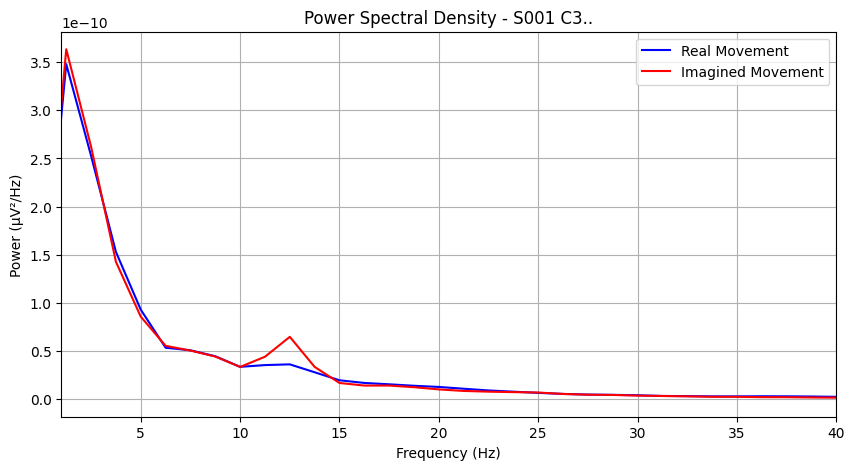

<Figure size 1000x500 with 0 Axes>

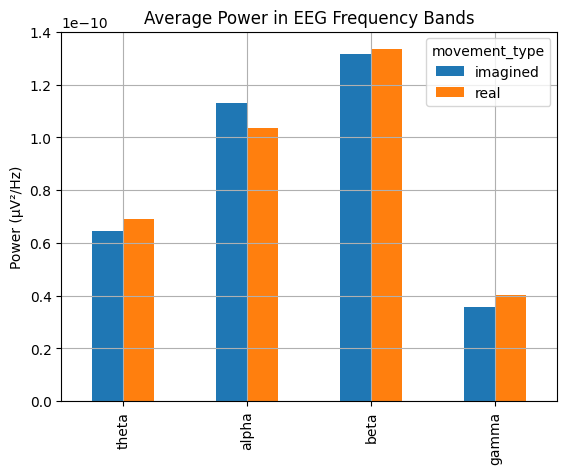

In [60]:
# Plot example PSD
plot_psd(subject="S001", channel="C3..")

# Plot band power distribution
plot_band_powers()

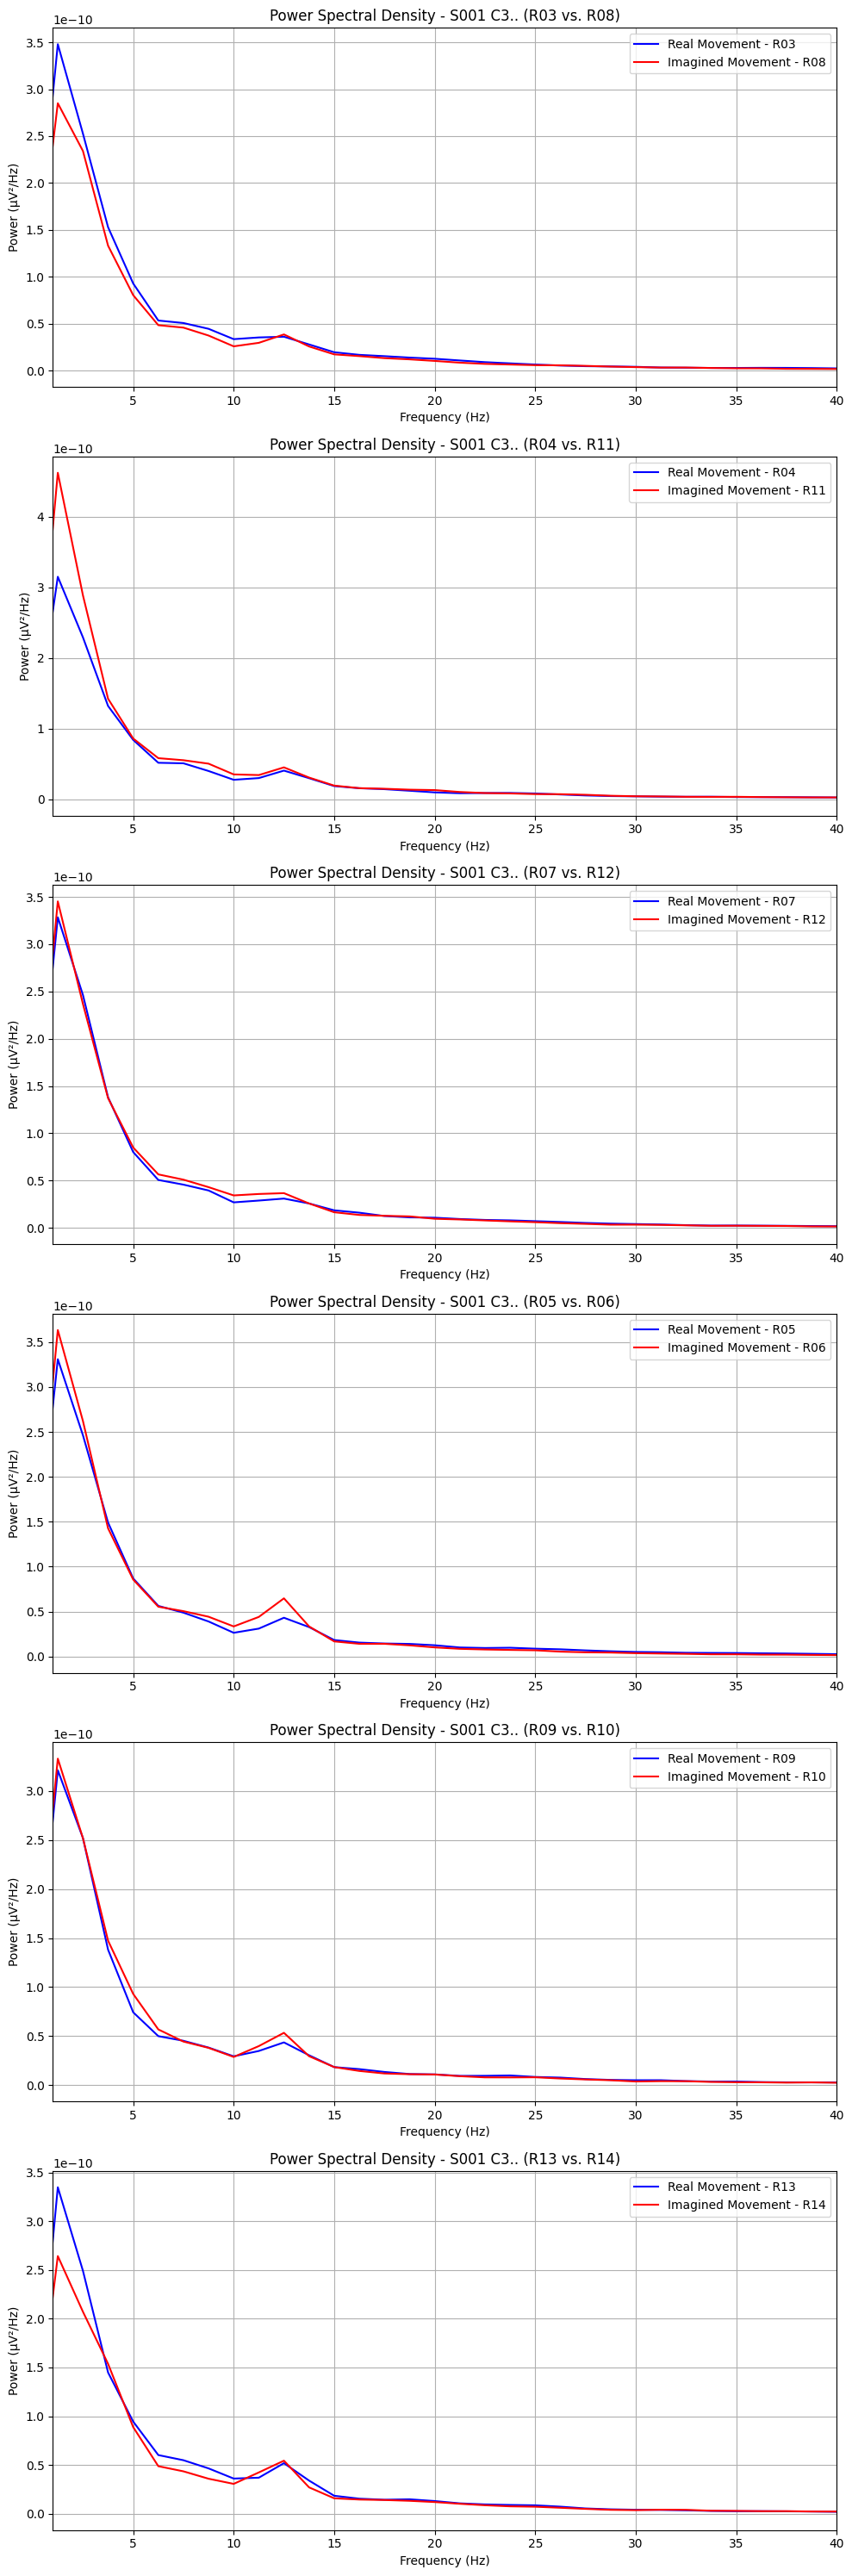

In [61]:
plot_psd_per_pair(subject="S001", channel="C3..")


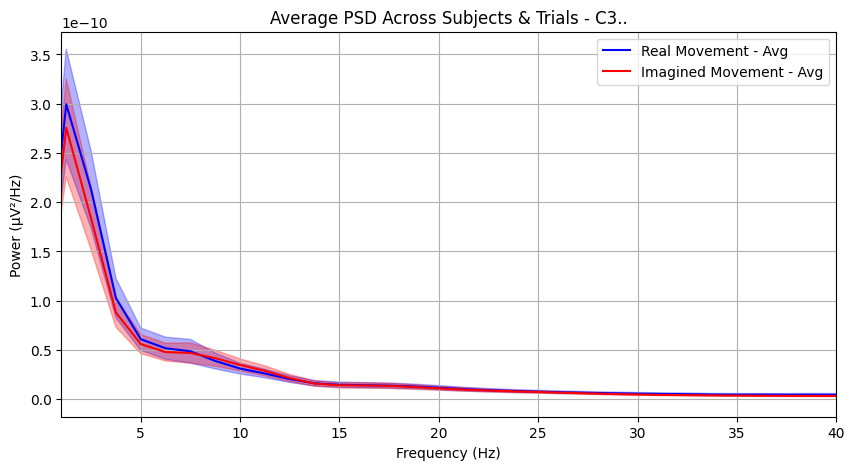

In [62]:
plot_avg_psd()